This notebook generates the data in Table 1 and Figures 1-5 of "An impossibility theorem concerning positive involvement in voting" by Wesley H. Holliday (wesholliday@berkeley.edu).

In [1]:
#!pip3 install pref_voting

import pref_voting
from pref_voting.profiles import *
from pref_voting.voting_methods import *
from pref_voting.generate_weighted_majority_graphs import enumerate_canonical_edge_ordered_tournaments

from ortools.linear_solver import pywraplp

print(pref_voting.__version__)

0.5.31


# Preliminaries

In [2]:
@vm(name = "Defensible Set")
def defensible_set(profile, curr_cands = None):
    """The defensible set is the set of candidates x such that for any candidate y, if x loses to y head-to-head, then there is some canidate z such that y loses to z head-to-head by at least as large of a margin as the margin by which x loses to y head-to-head."""

    curr_cands = profile.candidates if curr_cands is None else curr_cands

    defensible_set = curr_cands.copy()

    for x in curr_cands:
        for y in curr_cands:
            if profile.margin(y,x) > 0:
                defensible = False

                for z in curr_cands:
                    if profile.margin(z,y) > 0 and profile.margin(z,y) >= profile.margin(y,x):
                        defensible = True
                        break
                
                if x in defensible_set and not defensible:
                    defensible_set.remove(x) 
                    break            

    return defensible_set

# Table 1

In [3]:
@vm(name = "Defensible Smith")
def defensible_smith(profile, curr_cands = None):
    """Returns the intersection of the defensible set and Smith set"""
    return [c for c in defensible_set(profile,curr_cands) if c in smith_set(profile,curr_cands)]

In [4]:
vms_to_test = [smith_set, uc_gill, copeland, defensible_set, defensible_smith, split_cycle, minimax]

for vm in vms_to_test:
    num_graphs = 0
    num_graphs_multi_winners = 0
    num_winners = 0
    max_num_winners = 0

    for mg in enumerate_canonical_edge_ordered_tournaments(4):
        ws = vm(mg)
        num_graphs += 1
        num_winners += len(ws)
        if len(ws) > 1:
            num_graphs_multi_winners += 1

        if len(ws) > max_num_winners:
            max_num_winners = len(ws)

    print(f"{vm.name}")
    print("Number of graphs with multiple winners:", num_graphs_multi_winners)
    print("Average size of winning set:", num_winners/num_graphs)
    print("Max size of winning set:", max_num_winners)
    print("")


Smith Set
Number of graphs with multiple winners: 960
Average size of winning set: 2.375
Max size of winning set: 4

Uncovered Set
Number of graphs with multiple winners: 960
Average size of winning set: 2.0
Max size of winning set: 3

Copeland
Number of graphs with multiple winners: 960
Average size of winning set: 1.625
Max size of winning set: 3

Defensible Set
Number of graphs with multiple winners: 598
Average size of winning set: 1.359375
Max size of winning set: 3

Defensible Smith
Number of graphs with multiple winners: 583
Average size of winning set: 1.34375
Max size of winning set: 3

Split Cycle
Number of graphs with multiple winners: 104
Average size of winning set: 1.0541666666666667
Max size of winning set: 2

Minimax
Number of graphs with multiple winners: 0
Average size of winning set: 1.0
Max size of winning set: 1



# Figure 1

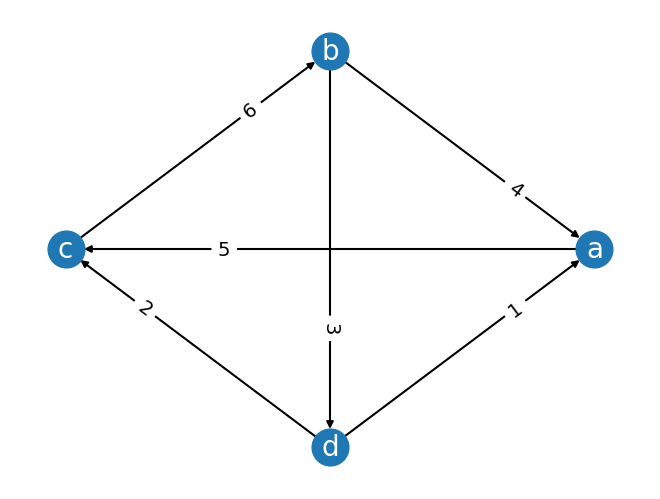

Defensible Set winners are {a, d}


In [5]:
M1 = MarginGraph([0,1,2,3], [(2,1,6), (0,2,5), (1,0,4), (1,3,3), (3,2,2), (3,0,1)], cmap = {0: 'a', 1: 'b', 2: 'c', 3: 'd'})
M1.display()
defensible_set.display(M1)

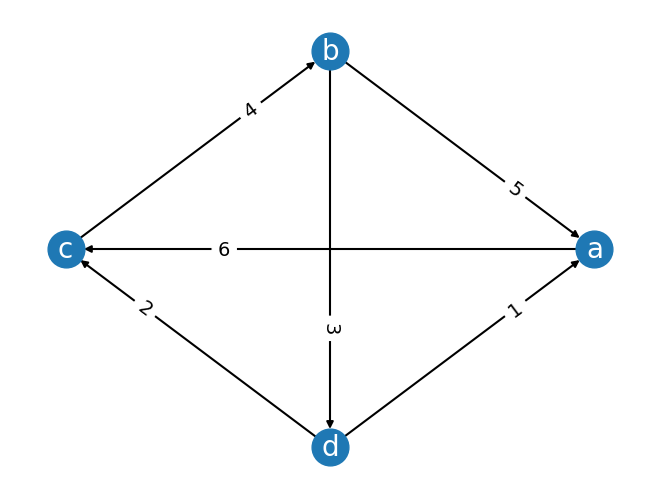

Defensible Set winners are {b, d}


In [6]:
M2 = MarginGraph([0,1,2,3], [(0,2,6), (1,0,5), (2,1,4), (1,3,3), (3,2,2), (3,0,1)], cmap = {0: 'a', 1: 'b', 2: 'c', 3: 'd'})
M2.display()
defensible_set.display(M2)

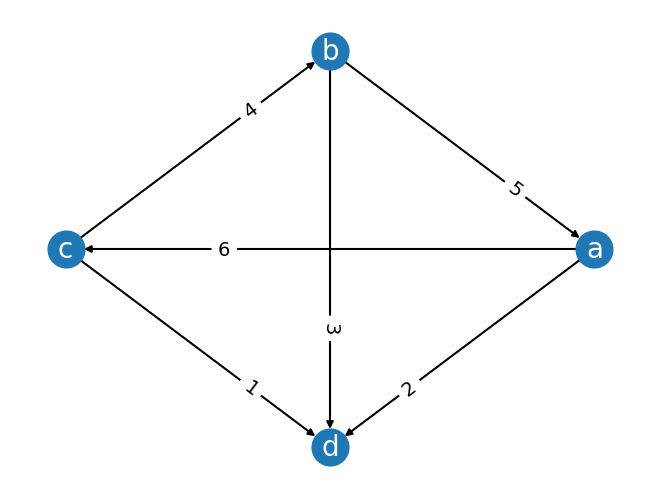

Defensible Set winners are {b, d}


In [7]:
M3 = MarginGraph([0,1,2,3], [(0,2,6), (1,0,5), (2,1,4), (1,3,3), (0,3,2), (2,3,1)], cmap = {0: 'a', 1: 'b', 2: 'c', 3: 'd'})
M3.display()
defensible_set.display(M3)

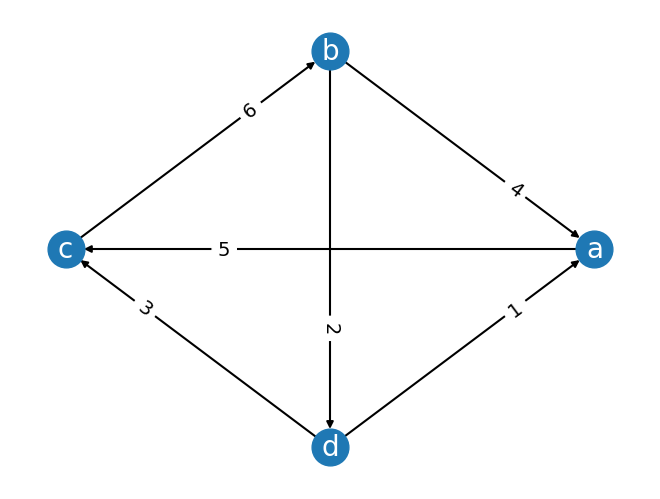

Defensible Set winners are {a, d}


In [8]:
M4 = MarginGraph([0,1,2,3], [(2,1,6), (0,2,5), (1,0,4), (3,2,3), (1,3,2), (3,0,1)], cmap = {0: 'a', 1: 'b', 2: 'c', 3: 'd'})
M4.display()
defensible_set.display(M4)

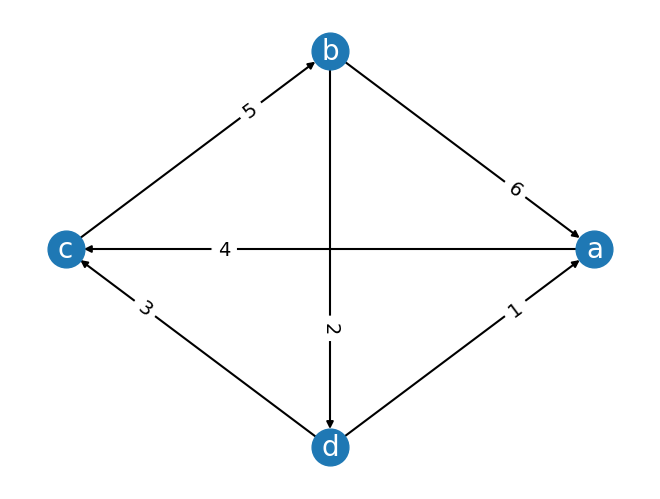

Defensible Set winner is {d}


In [10]:
M5 = MarginGraph([0,1,2,3], [(1,0,6), (2,1,5), (0,2,4), (3,2,3), (1,3,2), (3,0,1)], cmap = {0: 'a', 1: 'b', 2: 'c', 3: 'd'})
M5.display()
defensible_set.display(M5)

# Figures 2-5

Note that the linear programming solver has some non-determinism, so re-running the cells below may produce different profiles than those shown in the paper. 

The following function is a modification of the minimal_profile_from_edge_order function in pref_voting.

In [11]:
from ortools.linear_solver import pywraplp

def pi_profiles_from_edge_orders(cands, edge_order, new_edge_order, key_cand):
    """Given two relative margin graphs M and M' represented by edge_order and new_edge_order, use integer linear programming
    to find profiles P and P' such that M (resp. M') is the relative margin graph of P (resp. P') and
    P' is obtained from P by adding a coalition of voters who all rank key_cand uniquely first"""

    solver = pywraplp.Solver.CreateSolver("SAT")

    num_cands = len(cands)
    rankings = list(permutations(range(num_cands)))

    ranking_to_var = dict()
    infinity = solver.infinity()
    for ridx, r in enumerate(rankings): 
        _v = solver.IntVar(0.0, infinity, f"x{ridx}")
        ranking_to_var[r] = _v

    added_rankings_to_var = dict()
    for ridx, r in enumerate(rankings): 
        _v = solver.IntVar(0.0, infinity, f"y{ridx}")
        added_rankings_to_var[r] = _v

    nv = solver.IntVar(0.0, infinity, "nv")
    equations = list()
    
    for c1 in cands: 
        for c2 in cands: 
            if c1 != c2: 
                if (c1,c2) in edge_order:
                    rankings_c1_over_c2 = [ranking_to_var[r] for r in rankings if r.index(c1) < r.index(c2)]
                    rankings_c2_over_c1 = [ranking_to_var[r] for r in rankings if r.index(c2) < r.index(c1)]
                    equations.append(sum(rankings_c1_over_c2) - sum(rankings_c2_over_c1) >= 1)

                if (c1,c2) in new_edge_order:
                    new_rankings_c1_over_c2 = [ranking_to_var[r] for r in rankings if r.index(c1) < r.index(c2)] + [added_rankings_to_var[r] for r in rankings if r.index(c1) < r.index(c2)]
                    new_rankings_c2_over_c1 = [ranking_to_var[r] for r in rankings if r.index(c2) < r.index(c1)] + [added_rankings_to_var[r] for r in rankings if r.index(c2) < r.index(c1)]
                    equations.append(sum(new_rankings_c1_over_c2) - sum(new_rankings_c2_over_c1) >= 1)

                for c3 in cands:
                    for c4 in cands:
                        if c3 != c4:
                            if (c1,c2) in edge_order and (c3,c4) in edge_order and edge_order.index((c1,c2)) < edge_order.index((c3,c4)):
                                rankings_c3_over_c4 = [ranking_to_var[r] for r in rankings if r.index(c3) < r.index(c4)]
                                rankings_c4_over_c3 = [ranking_to_var[r] for r in rankings if r.index(c4) < r.index(c3)]
                                equations.append(sum(rankings_c1_over_c2) - sum(rankings_c2_over_c1) >= sum(rankings_c3_over_c4) - sum(rankings_c4_over_c3) + 1)

                            if (c1,c2) in new_edge_order and (c3,c4) in new_edge_order and new_edge_order.index((c1,c2)) < new_edge_order.index((c3,c4)):
                                new_rankings_c3_over_c4 = [ranking_to_var[r] for r in rankings if r.index(c3) < r.index(c4)] + [added_rankings_to_var[r] for r in rankings if r.index(c3) < r.index(c4)]
                                new_rankings_c4_over_c3 = [ranking_to_var[r] for r in rankings if r.index(c4) < r.index(c3)] + [added_rankings_to_var[r] for r in rankings if r.index(c4) < r.index(c3)]
                                equations.append(sum(new_rankings_c1_over_c2) - sum(new_rankings_c2_over_c1) >= sum(new_rankings_c3_over_c4) - sum(new_rankings_c4_over_c3) + 1)
                    
    equations.append(nv == sum(list(ranking_to_var.values())) + sum(list(added_rankings_to_var.values())))

    for r in rankings:
        if r.index(key_cand) != 0:
            equations.append(added_rankings_to_var[r] == 0)

    for eq in equations: 
        solver.Add(eq)

    solver.Minimize(nv)

    status = solver.Solve()

    if status == pywraplp.Solver.INFEASIBLE:
        print("Error: Did not find a solution.")


    if status != pywraplp.Solver.OPTIMAL: 
        print("Warning: Did not find an optimal solution.")

    _ranks = list()
    _rcounts = list()

    for r,v in ranking_to_var.items(): 

        if v.solution_value() > 0: 
            _ranks.append(r)
            _rcounts.append(int(v.solution_value()))
            if not v.solution_value().is_integer(): 
                print("ERROR: Found non integer, ", v.solution_value())

    _ranks_added = list()
    _rcounts_added = list()

    for r,v in added_rankings_to_var.items():

        if v.solution_value() > 0: 
            _ranks_added.append(r)
            _rcounts_added.append(int(v.solution_value()))
            if not v.solution_value().is_integer(): 
                print("ERROR: Found non integer, ", v.solution_value())

    _new_ranks = list()
    _new_rcounts = list()

    for r1, v1 in ranking_to_var.items():
        for r2, v2 in added_rankings_to_var.items():
            if r1 == r2:
                if v1.solution_value() + v2.solution_value() > 0:
                    _new_ranks.append(r1)
                    _new_rcounts.append(int(v1.solution_value() + v2.solution_value()))

    initial_prof = Profile(_ranks, rcounts = _rcounts)
    added_prof = Profile(_ranks_added, rcounts = _rcounts_added)
    new_prof = Profile(_new_ranks, rcounts = _new_rcounts)

    cmap = {0: 'a', 1: 'b', 2: 'c', 3: 'd'}

    print("Initial profile")
    initial_prof.display(cmap=cmap)
    #print(initial_prof.to_latex(cmap = cmap))

    pairs = [(c, d) for c in initial_prof.candidates for d in initial_prof.candidates if initial_prof.margin(c, d) > 0]
    sorted_pairs = sorted(pairs, key=lambda x: initial_prof.margin(x[0], x[1]), reverse=True)

    for c,d in sorted_pairs:
        print(cmap[c], "beats", cmap[d], "by", initial_prof.support(c,d), "-", initial_prof.support(d,c), "=", initial_prof.margin(c,d))
                
    initial_prof.display_margin_graph(cmap = cmap)
    defensible_set.display(initial_prof, cmap = cmap)
    print("")

    print("Added profile")
    added_prof.display(cmap = cmap)
    #print(added_prof.to_latex(cmap = cmap))
    #added_prof.display_margin_graph(cmap = cmap)
    print("")

    print("New profile")
    new_prof.display(cmap = cmap)
    #print(new_prof.to_latex(cmap = cmap))
    
    pairs = [(c, d) for c in new_prof.candidates for d in new_prof.candidates if new_prof.margin(c, d) > 0]
    sorted_pairs = sorted(pairs, key=lambda x: new_prof.margin(x[0], x[1]), reverse=True)

    for c,d in sorted_pairs:
        print(cmap[c], "beats", cmap[d], "by", new_prof.support(c,d), "-", new_prof.support(d,c), "=", new_prof.margin(c,d))

    new_prof.display_margin_graph()
    defensible_set.display(new_prof, cmap = cmap)

# Figure 2

Initial profile
+---+---+----+---+---+---+
| 8 | 8 | 14 | 6 | 7 | 2 |
+---+---+----+---+---+---+
| a | a | b  | c | c | d |
| c | d | d  | b | d | c |
| b | c | a  | a | b | b |
| d | b | c  | d | a | a |
+---+---+----+---+---+---+
c beats b by 31 - 14 = 17
a beats c by 30 - 15 = 15
b beats a by 29 - 16 = 13
b beats d by 28 - 17 = 11
d beats c by 24 - 21 = 3
d beats a by 23 - 22 = 1


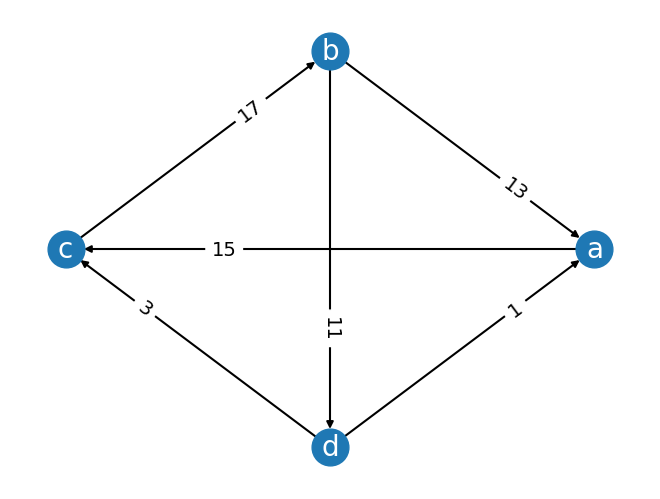

Defensible Set winners are {a, d}

Added profile
+---+
| 3 |
+---+
| d |
| b |
| a |
| c |
+---+

New profile
+---+---+----+---+---+---+---+
| 8 | 8 | 14 | 6 | 7 | 3 | 2 |
+---+---+----+---+---+---+---+
| a | a | b  | c | c | d | d |
| c | d | d  | b | d | b | c |
| b | c | a  | a | b | a | b |
| d | b | c  | d | a | c | a |
+---+---+----+---+---+---+---+
a beats c by 33 - 15 = 18
b beats a by 32 - 16 = 16
c beats b by 31 - 17 = 14
b beats d by 28 - 20 = 8
d beats c by 27 - 21 = 6
d beats a by 26 - 22 = 4


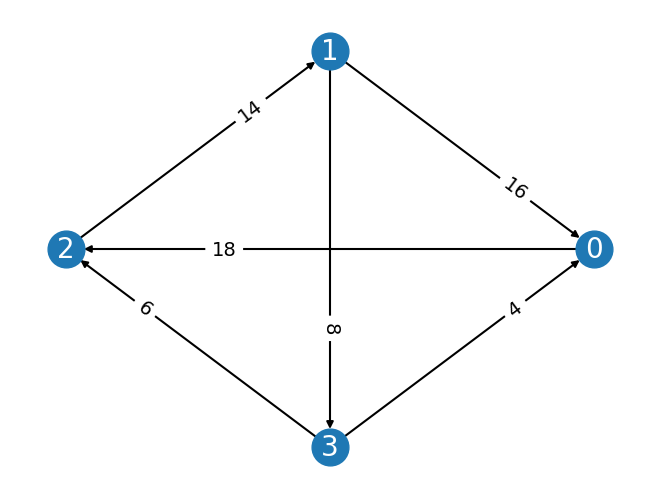

Defensible Set winners are {b, d}


In [12]:
cands = range(4)
M1_edge_order = [(2,1), (0,2), (1,0), (1,3), (3,2), (3,0)]
M2_edge_order = [(0,2), (1,0), (2,1), (1,3), (3,2), (3,0)]
key_cand = 3

pi_profiles_from_edge_orders(cands, M1_edge_order, M2_edge_order, key_cand)

# Figure 3

Initial profile
+----+----+---+---+---+----+
| 10 | 16 | 1 | 1 | 7 | 16 |
+----+----+---+---+---+----+
| a  | b  | b | b | d | d  |
| c  | a  | a | d | a | c  |
| b  | c  | d | a | c | b  |
| d  | d  | c | c | b | a  |
+----+----+---+---+---+----+
a beats c by 35 - 16 = 19
b beats a by 34 - 17 = 17
c beats b by 33 - 18 = 15
b beats d by 28 - 23 = 5
a beats d by 27 - 24 = 3
c beats d by 26 - 25 = 1


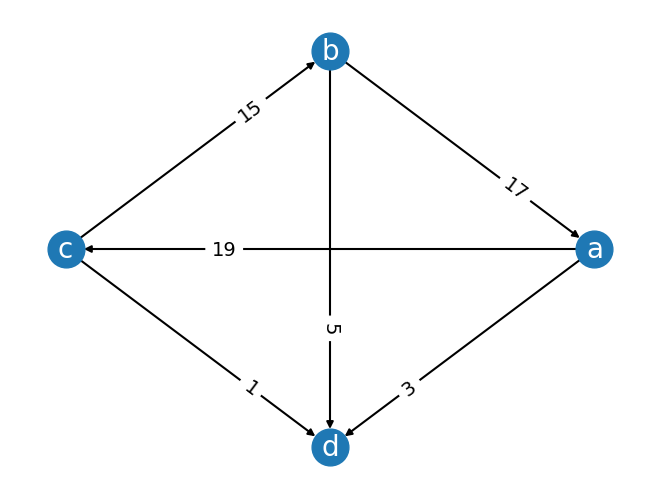

Defensible Set winners are {b, d}

Added profile
+---+
| 4 |
+---+
| b |
| d |
| a |
| c |
+---+

New profile
+----+----+---+---+---+----+
| 10 | 16 | 1 | 5 | 7 | 16 |
+----+----+---+---+---+----+
| a  | b  | b | b | d | d  |
| c  | a  | a | d | a | c  |
| b  | c  | d | a | c | b  |
| d  | d  | c | c | b | a  |
+----+----+---+---+---+----+
a beats c by 39 - 16 = 23
b beats a by 38 - 17 = 21
c beats b by 33 - 22 = 11
b beats d by 32 - 23 = 9
d beats c by 29 - 26 = 3
d beats a by 28 - 27 = 1


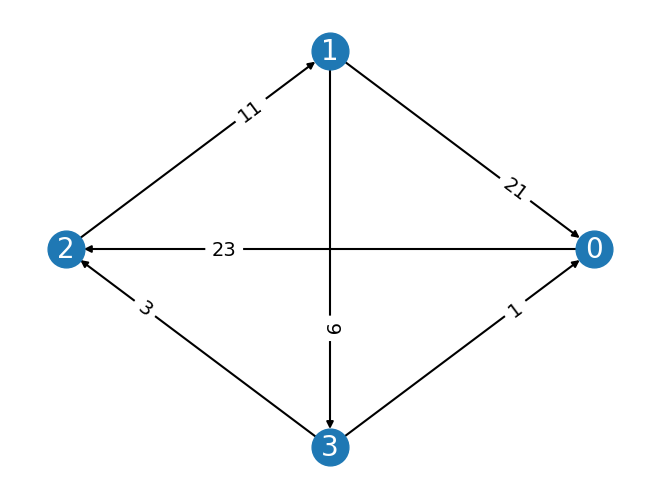

Defensible Set winners are {b, d}


In [24]:
M3_edge_order = [(0,2), (1,0), (2,1), (1,3), (0,3), (2,3)]
key_cand = 1

pi_profiles_from_edge_orders(cands, M3_edge_order, M2_edge_order, key_cand)

# Figure 4

Initial profile
+----+---+---+----+---+
| 14 | 4 | 8 | 11 | 2 |
+----+---+---+----+---+
| a  | b | b | c  | c |
| d  | a | d | b  | d |
| c  | c | a | d  | b |
| b  | d | c | a  | a |
+----+---+---+----+---+
c beats b by 27 - 12 = 15
a beats c by 26 - 13 = 13
b beats a by 25 - 14 = 11
b beats d by 23 - 16 = 7
d beats c by 22 - 17 = 5
d beats a by 21 - 18 = 3


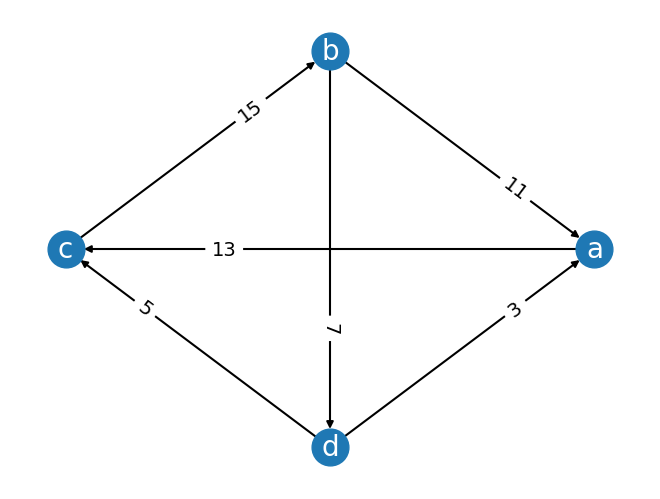

Defensible Set winners are {a, d}

Added profile
+---+
| 2 |
+---+
| a |
| d |
| c |
| b |
+---+

New profile
+----+---+---+----+---+
| 16 | 4 | 8 | 11 | 2 |
+----+---+---+----+---+
| a  | b | b | c  | c |
| d  | a | d | b  | d |
| c  | c | a | d  | b |
| b  | d | c | a  | a |
+----+---+---+----+---+
c beats b by 29 - 12 = 17
a beats c by 28 - 13 = 15
b beats a by 25 - 16 = 9
d beats c by 24 - 17 = 7
b beats d by 23 - 18 = 5
d beats a by 21 - 20 = 1


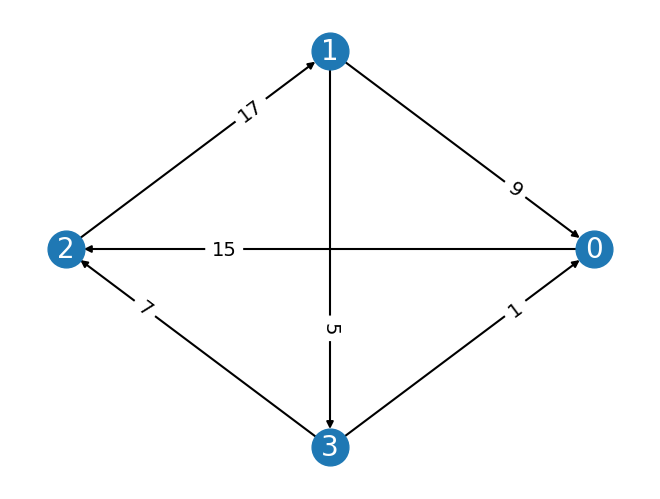

Defensible Set winners are {a, d}


In [28]:
M4_edge_order = [(2,1), (0,2), (1,0), (3,2), (1,3), (3,0)]
key_cand = 0

pi_profiles_from_edge_orders(cands, M1_edge_order, M4_edge_order, key_cand)

# Figure 5

Initial profile
+----+---+---+---+---+----+
| 16 | 9 | 5 | 4 | 3 | 14 |
+----+---+---+---+---+----+
| a  | b | b | c | d | d  |
| c  | a | d | d | b | c  |
| b  | d | a | b | a | b  |
| d  | c | c | a | c | a  |
+----+---+---+---+---+----+
b beats a by 35 - 16 = 19
c beats b by 34 - 17 = 17
a beats c by 33 - 18 = 15
d beats c by 31 - 20 = 11
b beats d by 30 - 21 = 9
d beats a by 26 - 25 = 1


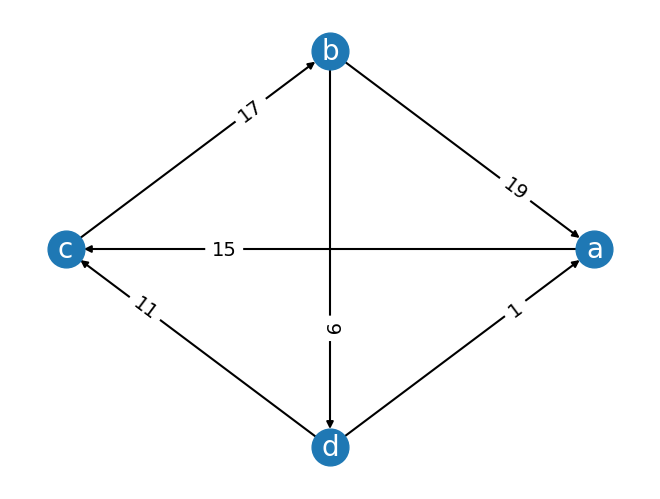

Defensible Set winner is {d}

Added profile
+---+
| 3 |
+---+
| d |
| a |
| c |
| b |
+---+

New profile
+----+---+---+---+---+---+----+
| 16 | 9 | 5 | 4 | 3 | 3 | 14 |
+----+---+---+---+---+---+----+
| a  | b | b | c | d | d | d  |
| c  | a | d | d | a | b | c  |
| b  | d | a | b | c | a | b  |
| d  | c | c | a | b | c | a  |
+----+---+---+---+---+---+----+
c beats b by 37 - 17 = 20
a beats c by 36 - 18 = 18
b beats a by 35 - 19 = 16
d beats c by 34 - 20 = 14
b beats d by 30 - 24 = 6
d beats a by 29 - 25 = 4


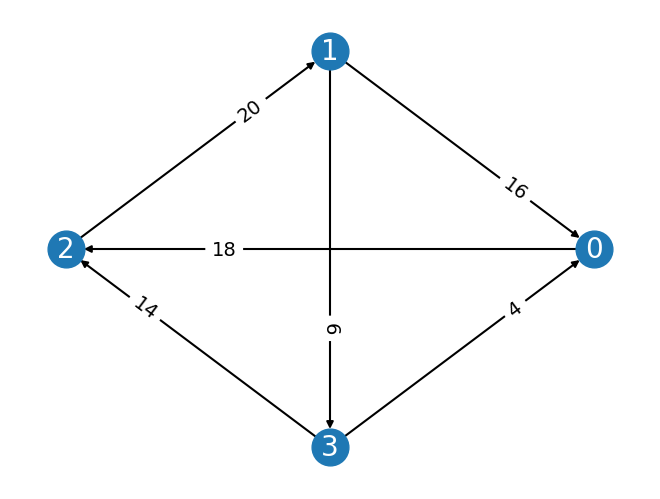

Defensible Set winners are {a, d}


In [26]:
M5_edge_order = [(1,0), (2,1), (0,2), (3,2), (1,3), (3,0)]

pi_profiles_from_edge_orders(cands, M5_edge_order, M4_edge_order, key_cand = 3)